<a href="https://colab.research.google.com/github/besomlu/stock_simulation/blob/main/3_Larry_Cornnors_RSI(2)_%EC%97%AD%EC%B6%94%EC%84%B8_%EC%A0%84%EB%9E%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Colab에서 실행 가능한 파이썬 코드를 만들어줘. 아래 조건을 모두 만족해야 해:

1. 나눔고딕 폰트를 설치하고 폰트매니저에 설치된 폰트를 모두 등록할 것 matplotlib에서 한글이 잘 보이도록 설정할 것
2. FinanceDataReader를 설치하고 사용할 것
3. 종가가 200일 이동평균선 위에 있을 때, 2일 기준 RSI 지수가 5이하로 떨어지면 다음날 시가에 매수할 것
4. 매수한 상황에서 당일 종가가 전일 고가를 상회하면 다음날 시가에 매도할 것
5. 매수한 상황에서 종가가 200일 이동평균선 아래로 떨어지면 다음날 시가에 매도할 것
6. 종목은 QQQ, TQQQ로 하고 log scale로 총 수익 그래프를 그릴 것. 초기자본은 1000달라로 할 것
7. 추가로  QQQ를 buy and hold한 경우와도 함께 비교하게 그래프를 그릴 것
7. 기간은 2000년 1월 1일부터 2025년 6월 3일로 할 것

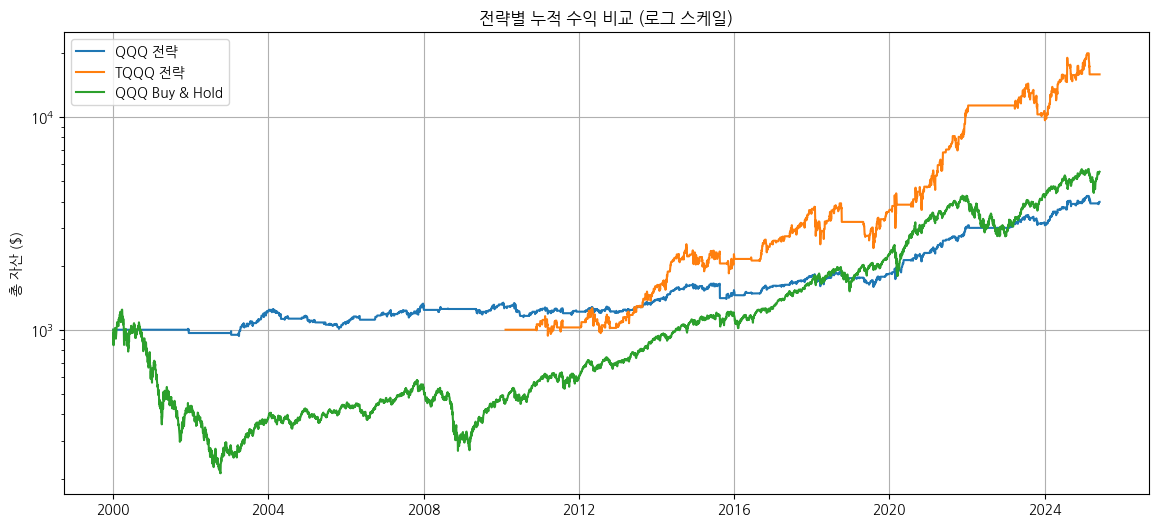

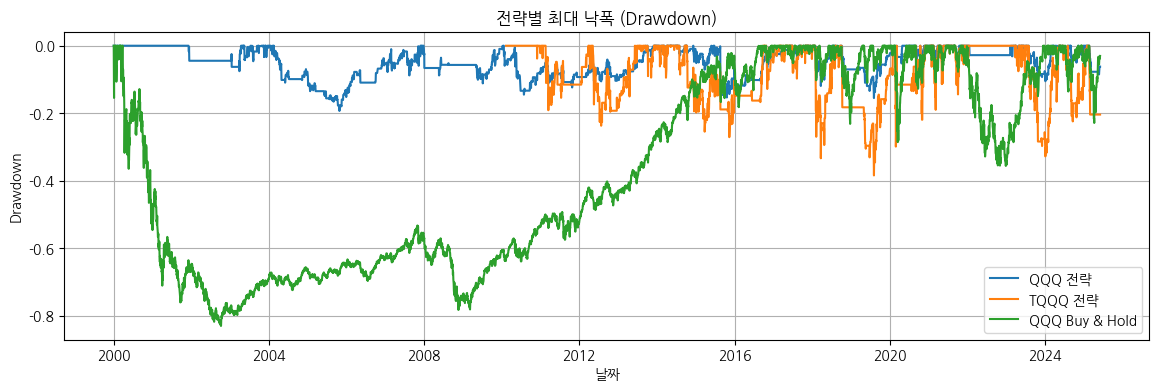

In [ ]:
# 1. 설치
!pip install -q finance-datareader
!apt-get -qq install -y fonts-nanum
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import FinanceDataReader as fdr

# 2. 한글 폰트 설정
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for f in font_files:
    fm.fontManager.addfont(f)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 3. RSI 계산
def compute_rsi(series: pd.Series, period: int = 2) -> pd.Series:
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-6)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 4. 백테스트 함수
def backtest_strategy(symbol: str, initial_cash: float = 1000.0):
    df = fdr.DataReader(symbol, '2000-01-01', '2025-06-03')
    df = df[['Open', 'High', 'Close']].dropna()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['RSI2'] = compute_rsi(df['Close'], 2)

    position = 0
    cash = initial_cash
    shares = 0
    equity = []
    prev_high = None

    for i in range(len(df) - 1):
        today = df.iloc[i]
        tomorrow = df.iloc[i + 1]
        date = df.index[i]

        # 매수 조건
        if position == 0 and today['Close'] > today['MA200'] and today['RSI2'] <= 5:
            shares = cash / tomorrow['Open']
            cash = 0
            position = 1

        # 매도 조건
        elif position == 1 and (
            today['Close'] > prev_high or today['Close'] < today['MA200']
        ):
            cash = shares * tomorrow['Open']
            shares = 0
            position = 0

        prev_high = today['High']
        total_equity = cash if position == 0 else shares * today['Close']
        equity.append((date, total_equity))

    # 마지막 날 평가
    final_price = df.iloc[-1]['Close']
    final_date = df.index[-1]
    if position == 1:
        equity.append((final_date, shares * final_price))
    else:
        equity.append((final_date, cash))

    return pd.DataFrame(equity, columns=['Date', 'TotalValue']).set_index('Date')

# 5. Buy and Hold 함수
def buy_and_hold(symbol: str, initial_cash: float = 1000.0):
    df = fdr.DataReader(symbol, '2000-01-01', '2025-06-03')
    df = df[['Close']].dropna()
    shares = initial_cash / df.iloc[0]['Close']
    df['TotalValue'] = shares * df['Close']
    return df[['TotalValue']]

# 6. Drawdown 계산 함수
def compute_drawdown(df: pd.DataFrame) -> pd.Series:
    peak = df['TotalValue'].cummax()
    drawdown = (df['TotalValue'] - peak) / peak
    return drawdown

# 7. 전략 실행
qqq_strat = backtest_strategy('QQQ')
tqqq_strat = backtest_strategy('TQQQ')
qqq_hold = buy_and_hold('QQQ')

qqq_strat_dd = compute_drawdown(qqq_strat)
tqqq_strat_dd = compute_drawdown(tqqq_strat)
qqq_hold_dd = compute_drawdown(qqq_hold)

# 8. 그래프 그리기
plt.figure(figsize=(14, 6))
plt.title("전략별 누적 수익 비교 (로그 스케일)")
plt.plot(qqq_strat.index, qqq_strat['TotalValue'], label='QQQ 전략')
plt.plot(tqqq_strat.index, tqqq_strat['TotalValue'], label='TQQQ 전략')
plt.plot(qqq_hold.index, qqq_hold['TotalValue'], label='QQQ Buy & Hold')
plt.yscale('log')
plt.ylabel("총 자산 ($)")
plt.legend()
plt.grid(True)
plt.show()

# 9. Drawdown 그래프
plt.figure(figsize=(14, 4))
plt.title("전략별 최대 낙폭 (Drawdown)")
plt.plot(qqq_strat_dd.index, qqq_strat_dd, label='QQQ 전략')
plt.plot(tqqq_strat_dd.index, tqqq_strat_dd, label='TQQQ 전략')
plt.plot(qqq_hold_dd.index, qqq_hold_dd, label='QQQ Buy & Hold')
plt.ylabel("Drawdown")
plt.xlabel("날짜")
plt.legend()
plt.grid(True)
plt.show()


# 결과적으로 누적 수익을 보면 QQQ Buy and Hold보다 이 전략은 안좋은 성과를 냈네요. 블로그에는 이후에 다양한 내용의 글이 있으니 확인하시면 좋겠습니다.

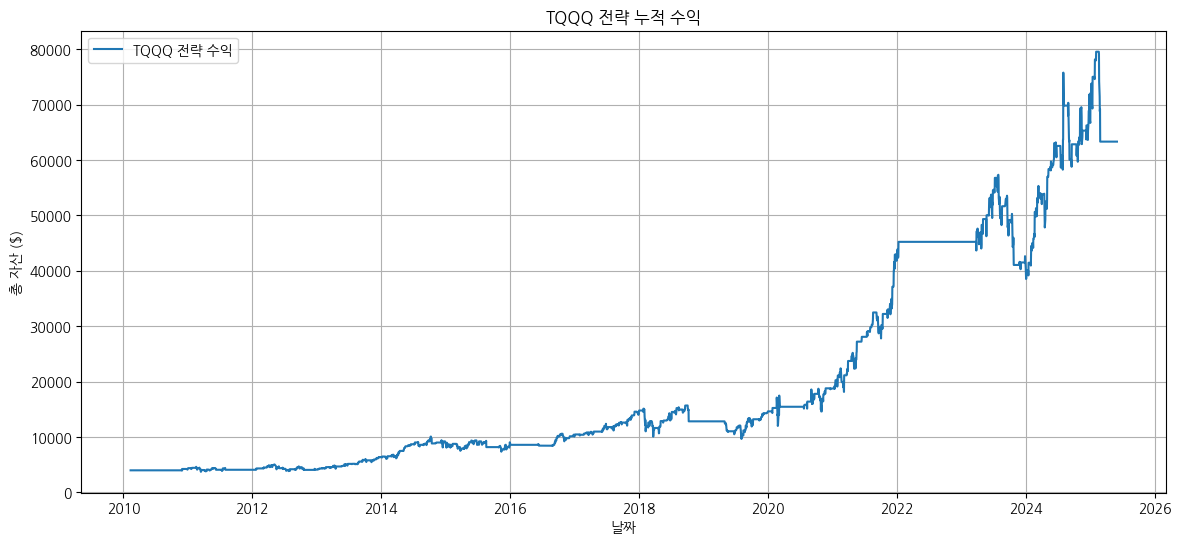

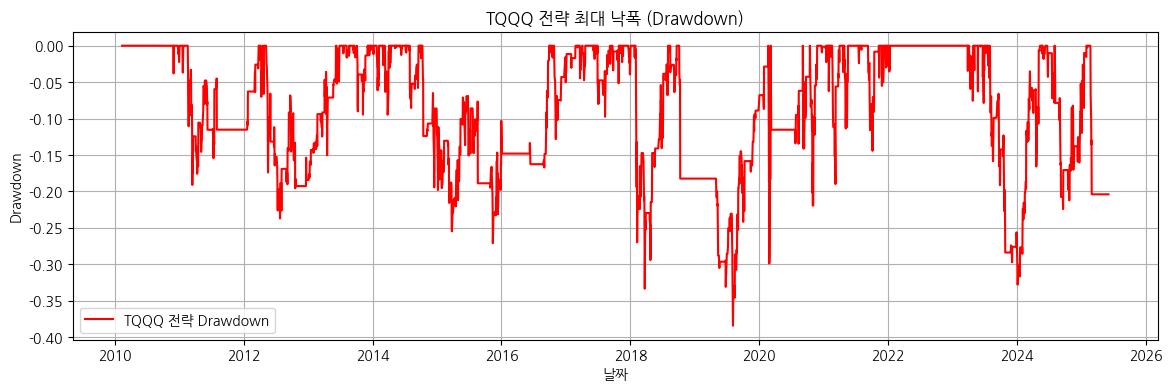

In [ ]:
# 1. 설치 및 폰트 설정
!pip install -q finance-datareader
!apt-get -qq install -y fonts-nanum
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import FinanceDataReader as fdr

# 나눔고딕 폰트 등록
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for f in font_files:
    fm.fontManager.addfont(f)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 2. RSI(2) 계산 함수
def compute_rsi(series: pd.Series, period: int = 2) -> pd.Series:
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-6)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 3. 전략 백테스트 함수
def backtest_strategy(symbol: str, initial_cash: float = 4000.0):
    df = fdr.DataReader(symbol, '2000-01-01', '2025-06-03')
    df = df[['Open', 'High', 'Close']].dropna()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['RSI2'] = compute_rsi(df['Close'], 2)

    position = 0
    cash = initial_cash
    shares = 0
    equity = []
    prev_high = None

    for i in range(len(df) - 1):
        today = df.iloc[i]
        tomorrow = df.iloc[i + 1]
        date = df.index[i]

        # 매수 조건
        if position == 0 and today['Close'] > today['MA200'] and today['RSI2'] <= 5:
            shares = cash / tomorrow['Open']
            cash = 0
            position = 1

        # 매도 조건
        elif position == 1 and (
            today['Close'] > prev_high or today['Close'] < today['MA200']
        ):
            cash = shares * tomorrow['Open']
            shares = 0
            position = 0

        prev_high = today['High']
        total_equity = cash if position == 0 else shares * today['Close']
        equity.append((date, total_equity))

    # 마지막 날 평가
    final_price = df.iloc[-1]['Close']
    final_date = df.index[-1]
    if position == 1:
        equity.append((final_date, shares * final_price))
    else:
        equity.append((final_date, cash))

    return pd.DataFrame(equity, columns=['Date', 'TotalValue']).set_index('Date')

# 4. Drawdown 계산 함수
def compute_drawdown(df: pd.DataFrame) -> pd.Series:
    peak = df['TotalValue'].cummax()
    drawdown = (df['TotalValue'] - peak) / peak
    return drawdown

# 5. 전략 실행
tqqq_result = backtest_strategy('TQQQ')
tqqq_drawdown = compute_drawdown(tqqq_result)

# 6. 누적 수익 그래프
plt.figure(figsize=(14, 6))
plt.plot(tqqq_result.index, tqqq_result['TotalValue'], label='TQQQ 전략 수익')
plt.title("TQQQ 전략 누적 수익")
plt.xlabel("날짜")
plt.ylabel("총 자산 ($)")
plt.grid(True)
plt.legend()
plt.show()

# 7. Drawdown 그래프
plt.figure(figsize=(14, 4))
plt.plot(tqqq_drawdown.index, tqqq_drawdown, label='TQQQ 전략 Drawdown', color='red')
plt.title("TQQQ 전략 최대 낙폭 (Drawdown)")
plt.xlabel("날짜")
plt.ylabel("Drawdown")
plt.grid(True)
plt.legend()
plt.show()


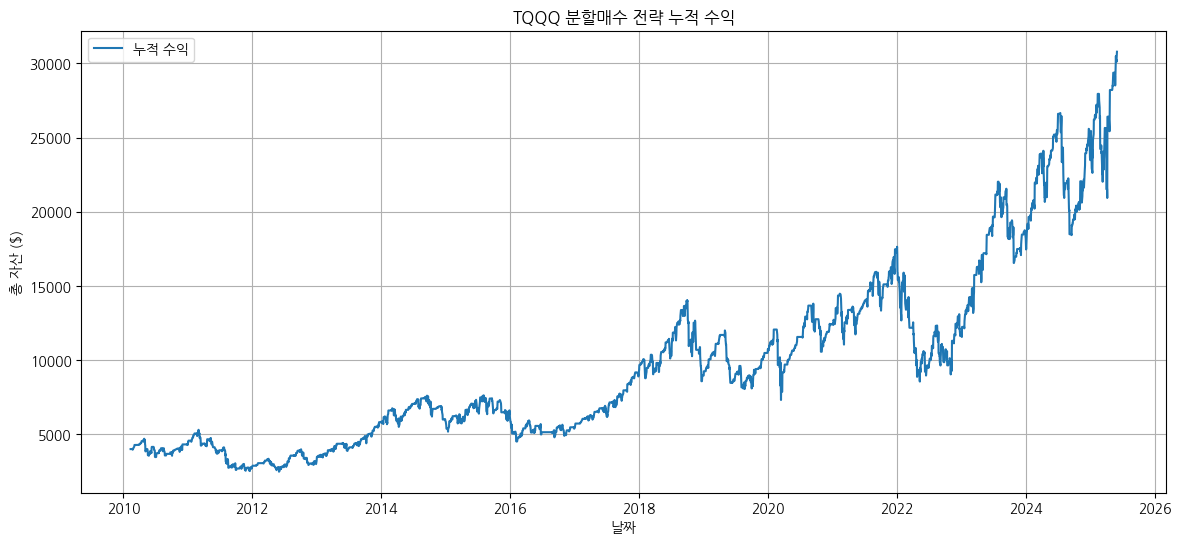

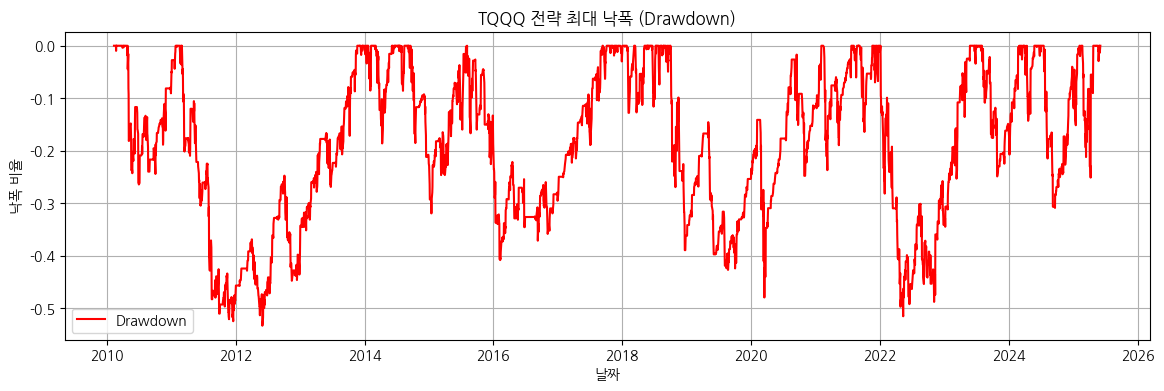

In [ ]:
# 1. 설치 및 한글 폰트 설정
!pip install -q finance-datareader
!apt-get -qq install -y fonts-nanum > /dev/null
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import FinanceDataReader as fdr

# 나눔고딕 폰트 등록
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for f in font_files:
    fm.fontManager.addfont(f)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 2. RSI(2) 계산 함수
def compute_rsi(series: pd.Series, period: int = 2) -> pd.Series:
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-6)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 3. 백테스트 함수
def backtest_split_buy_strategy(symbol='TQQQ', initial_cash=4000):
    df = fdr.DataReader(symbol, '2000-01-01', '2025-06-03')
    df = df[['Close']].dropna()
    df['RSI2'] = compute_rsi(df['Close'], 2)

    equity_curve = []
    cash = initial_cash
    holding = 0
    buy_prices = []
    position = 0  # 0~4

    for i in range(len(df)):
        today = df.iloc[i]
        date = df.index[i]
        price = today['Close']
        rsi = today['RSI2']

        # 매수 조건 (최대 4회)
        if rsi <= 25 and position < 4:
            invest_amount = cash / (4 - position)
            num_shares = invest_amount / price
            holding += num_shares
            cash -= num_shares * price
            buy_prices.append(price)
            position += 1

        # 평가 금액
        total_value = cash + holding * price
        avg_buy_price = np.mean(buy_prices) if buy_prices else 0
        gain = (price - avg_buy_price) / avg_buy_price * 100 if avg_buy_price > 0 else 0

        # 매도 조건
        if position in [1, 2] and gain >= 10:
            cash += holding * price
            holding = 0
            position = 0
            buy_prices = []
        elif position in [3, 4] and gain >= 5:
            cash += holding * price
            holding = 0
            position = 0
            buy_prices = []
        elif position == 4 and gain <= -10:
            cash += holding * price
            holding = 0
            position = 0
            buy_prices = []

        equity_curve.append((date, cash + holding * price))

    result_df = pd.DataFrame(equity_curve, columns=['Date', 'TotalValue']).set_index('Date')
    return result_df

# 4. Drawdown 계산 함수
def compute_drawdown(df: pd.DataFrame) -> pd.Series:
    peak = df['TotalValue'].cummax()
    drawdown = (df['TotalValue'] - peak) / peak
    return drawdown

# 5. 실행 및 시각화
result = backtest_split_buy_strategy()
drawdown = compute_drawdown(result)

# 누적 수익 그래프
plt.figure(figsize=(14, 6))
plt.plot(result.index, result['TotalValue'], label='누적 수익')
plt.title('TQQQ 분할매수 전략 누적 수익')
plt.xlabel('날짜')
plt.ylabel('총 자산 ($)')
plt.grid(True)
plt.legend()
plt.show()

# Drawdown 그래프
plt.figure(figsize=(14, 4))
plt.plot(drawdown.index, drawdown, color='red', label='Drawdown')
plt.title('TQQQ 전략 최대 낙폭 (Drawdown)')
plt.xlabel('날짜')
plt.ylabel('낙폭 비율')
plt.grid(True)
plt.legend()
plt.show()
